# 📊 Análisis Post-Modelo del Dataset

En esta sección se analiza el desempeño del modelo final sobre el **conjunto de test**, centrándonos en:

- Evaluar cómo funciona el modelo globalmente
- Analizar el rendimiento por grupos académicos (titulación, etapa y subetapa)
- Detectar posibles sesgos o áreas con bajo desempeño
- Generar alertas y recomendaciones para la mejora del modelo o la recolección de datos

El objetivo es entender no solo **qué tan preciso es el modelo**, sino **dónde funciona mejor y dónde falla**.

---

## 1️⃣ Carga del Modelo Final y del Conjunto de Test

- El modelo ya entrenado se carga desde el almacenamiento definido (`modelo_final_explicable`).  
- Se extrae el conjunto de test correspondiente al **último curso académico** para garantizar que los datos no hayan sido vistos durante el entrenamiento.  
- Se preparan las variables de modelado y el target para la predicción.

📌 Esto asegura que las métricas calculadas reflejen el **rendimiento real del modelo** sobre datos nuevos.

---

## 2️⃣ Predicciones del Modelo

- Se calculan:

  - **Etiquetas predichas** (`prediction_label`)  
  - **Probabilidades de éxito** (`prediction_score`)

- Se reengancha el target real para poder comparar las predicciones con los resultados reales.  

📌 Esto permite calcular métricas como **Accuracy** y **AUC** tanto de forma global como por grupos.

---

## 3️⃣ Análisis por Grupos Académicos

Se realiza un desglose del desempeño del modelo por:

1. **Titulación (`TITULACION`)**
2. **Etapa (`PL_ETAPA`)**
3. **Subetapa (`PL_SUBETAPA`)**, si existe en el dataset

Para cada grupo se calcula:

- Número de observaciones (`n`)  
- **Accuracy**: porcentaje de aciertos  
- **AUC**: capacidad del modelo para discriminar entre clases

Además, se identifican automáticamente los **5 mejores y 5 peores grupos** según Accuracy.

---

## 4️⃣ Visualización de Resultados

- Se generan **gráficos de barras** mostrando los grupos con mejor desempeño.  
- Esto permite identificar visualmente:

  - Qué titulaciones, etapas o subetapas presentan mayor confiabilidad en las predicciones
  - Qué grupos podrían requerir atención o revisión de datos

📌 La visualización facilita la interpretación de los resultados por stakeholders académicos.

---

## 5️⃣ Alertas y Recomendaciones Automáticas

- Se generan alertas para grupos con **Accuracy por debajo de un umbral configurable** (por ejemplo, 0.7).  
- Esto ayuda a:

  - Detectar titulaciones o etapas donde el modelo es menos fiable  
  - Tomar decisiones sobre **recolección de datos adicional** o **revisión de características del grupo**  
  - Priorizar intervenciones en los grupos con peor desempeño

---

## 6️⃣ Interpretación de Resultados

- Los grupos con **Accuracy alta (>0.9)** indican que el modelo predice muy bien el éxito de los candidatos.  
- Los grupos con **Accuracy baja (<0.6–0.7)** requieren atención, ya que el modelo podría estar sesgado o los datos ser insuficientes o ruidosos.  
- El análisis por **AUC** complementa el análisis de Accuracy, mostrando la capacidad de discriminación del modelo incluso si los grupos son desbalanceados.

---

## 7️⃣ Beneficios de Este Análisis

- Permite evaluar el **rendimiento real del modelo** más allá de las métricas globales.  
- Facilita la identificación de **sesgos por segmentación académica**.  
- Proporciona información clave para mejorar:

  - Estrategias de admisión o seguimiento de candidatos  
  - Preparación de submodelos específicos por áreas  
  - Recolección y limpieza de datos en grupos críticos  

📌 Los resultados obtenidos en esta fase **cierran el ciclo de modelado**, conectando la predicción con decisiones operativas y estratégicas.


---


Transformation Pipeline and Model Successfully Loaded
✅ Modelo cargado correctamente.
⚠️ No hay cursos válidos. Se usará todo el dataset de test.
✅ Filas de test después de eliminar NaN en target: 536598
✅ Predicciones realizadas. Número de filas: 536598

📊 Resultados por TITULACION (top 5):
                                           TITULACION   n  AUC  Accuracy  \
0  Doble Máster en Ingeniería de Telecomunicación...  17  NaN       1.0   
1        Doble Grado Filología Hispánica/ Periodismo   3  NaN       1.0   
2                Grado en Marketing + Global Affairs  96  NaN       1.0   
3  Grado en Administración y Dirección de Empresa...   5  NaN       1.0   
4                 Grado en Marketing + Tech and Data  43  NaN       1.0   

   Accuracy_0  Accuracy_1  
0         1.0         NaN  
1         1.0         NaN  
2         1.0         NaN  
3         1.0         NaN  
4         1.0         NaN  

⚠️ Peores 5 TITULACION:
                                             TITULACION   n  A

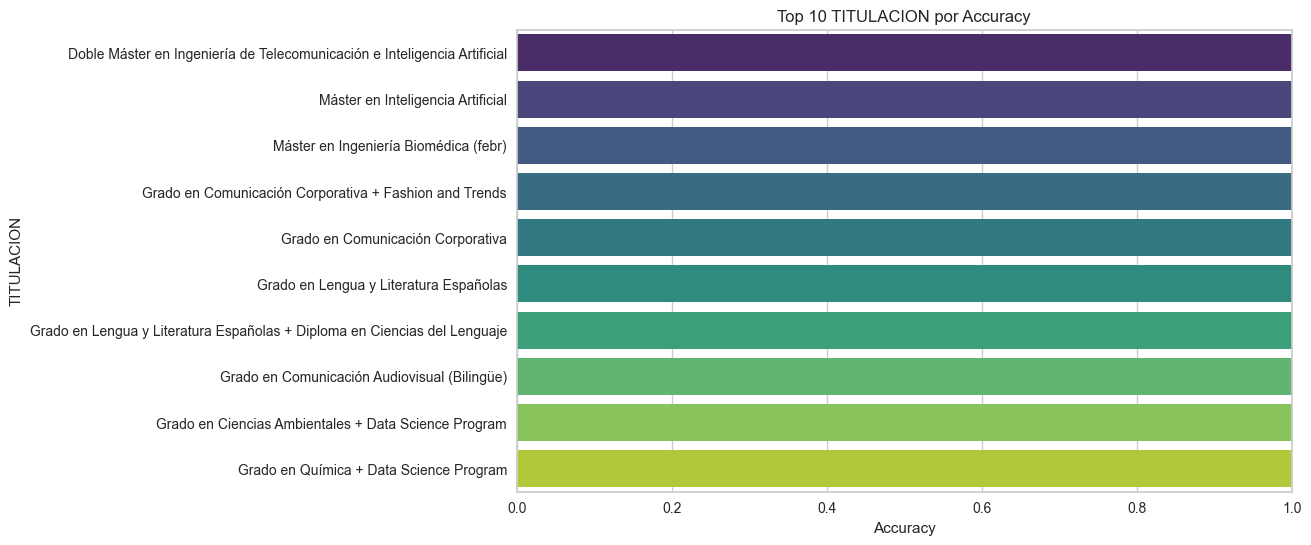


⚠️ ALERTA: 31 TITULACION con Accuracy < 0.7:
                                            TITULACION  Accuracy     n
243    Máster en Psicología General Sanitaria (Madrid)     0.698  2777
244           Diploma de Filosofía, Ciencia y Religión     0.660    53
245              Máster en Dirección de Empresas (MBA)     0.640    25
246                   Master in Near Eastern Languages     0.593    27
247  Alumno extraordinario (Facultad de Teología-Gr...     0.571     7
248        International Industrial Management Program     0.551    69
249  Alumno extraordinario (Facultad de Filosofía y...     0.545    33
250  Alumno extraordinario (Facultad de Educación-G...     0.545    22
251  Máster Ejecutivo Global en Dirección de Empres...     0.538    26
252  Alumno extraordinario (Facultad de Derecho-Grado)     0.524    21
253  Grado en Pedagogía + Diploma en educación inte...     0.509    53
254  Máster Universitario en Práctica Avanzada de E...     0.500   126
255  Alumno extraordinario (Fac

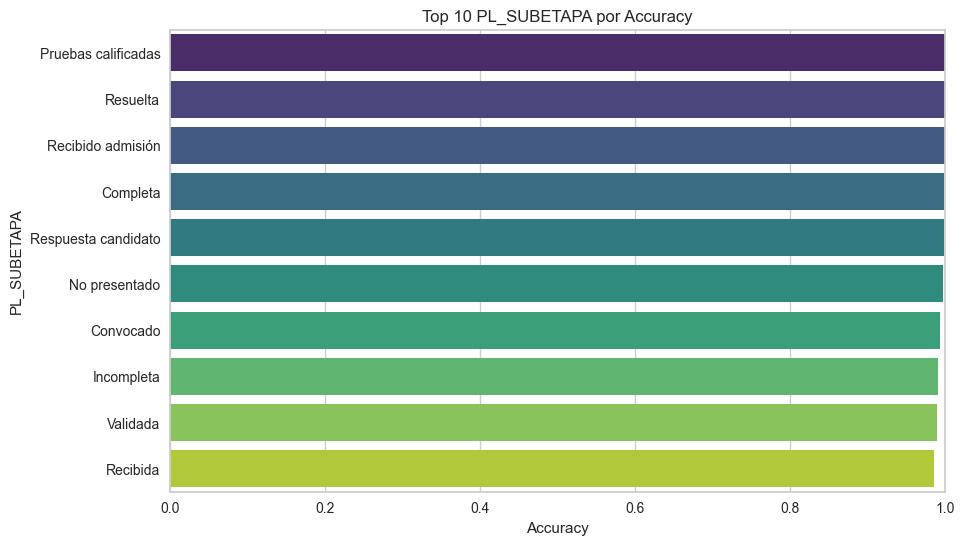


⚠️ ALERTA: 5 PL_SUBETAPA con Accuracy < 0.7:
                 PL_SUBETAPA  Accuracy      n
15                    Inicio     0.625   9451
16                   Enviada     0.455     33
17  Matriculado parcialmente     0.428  13886
18            Prematriculado     0.094    722
19               Pago mínimo     0.060    416

✅ Análisis post-modelo completado con accuracy por clase y sin errores de NaN.


In [ ]:
# ============================================================
# SCRIPT POST-MODELO COMPLETO CON ACCURACY POR CLASE (CORREGIDO)
# ============================================================

import pandas as pd
import numpy as np
from pycaret.classification import load_model, predict_model
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# 0️⃣ CARGA DEL MODELO
# ============================================================
ruta_modelo = r"..\datos\04. Modelos\modelo_final_explicable"
modelo = load_model(ruta_modelo)
print("✅ Modelo cargado correctamente.")

# ============================================================
# 1️⃣ CARGA DEL DATASET DE TEST
# ============================================================
ruta_dataset = r"..\datos\03. Datos analizados\dataset_clusterizado.csv"
df = pd.read_csv(ruta_dataset, sep=";")
target = 'target'

# Convertir PL_CURSO_ACADEMICO a numérico
df['PL_CURSO_ACADEMICO'] = pd.to_numeric(df['PL_CURSO_ACADEMICO'], errors='coerce')

# Filtrar por curso académico más reciente
if df['PL_CURSO_ACADEMICO'].dropna().empty:
    test_df_full = df.copy()
    print("⚠️ No hay cursos válidos. Se usará todo el dataset de test.")
else:
    ultimo_curso = df['PL_CURSO_ACADEMICO'].max()
    test_df_full = df[df['PL_CURSO_ACADEMICO'] == ultimo_curso].copy()
    print(f"✅ Datos de test filtrados por curso {ultimo_curso}. Filas: {len(test_df_full)}")

# ============================================================
# 2️⃣ FILTRAR NAs DEL TARGET
# ============================================================
test_df_full = test_df_full.dropna(subset=[target]).reset_index(drop=True)
print(f"✅ Filas de test después de eliminar NaN en target: {len(test_df_full)}")

# ============================================================
# 3️⃣ VARIABLES DEL MODELO
# ============================================================
vars_excluir = [
    target, 'desmatriculado', 'PAID_PERCENT', 'MINIMUMPAYMENTPAYED',
    'CH_PAGO_SUPERIOR', 'STAGENAME', 'PL_SUBETAPA',
    'ACC_DTT_FECHAULTIMAACTIVIDAD', 'NAMEX', 'YEARPERSONBIRTHDATE'
]

test_X = test_df_full[[c for c in test_df_full.columns if c not in vars_excluir]].copy()
test_y = test_df_full[target].reset_index(drop=True)

# ============================================================
# 4️⃣ RECONSTRUIR FLAGS DE NA Y RELLENAR NAs
# ============================================================
vars_cero_logico = [
    'NU_NOTA_MEDIA_ADMISION',
    'NU_NOTA_MEDIA_1_BACH__PC',
    'NU_RESULTADO_ADMISION_PUNTOS',
    'CU_IMPORTE_TOTAL',
    'CU_precioOrdinario_def__c',
    'CU_precioAplicado_def__c'
]

for v in vars_cero_logico:
    if v in test_X.columns:
        test_X[f'flag_{v}_na'] = test_X[v].isna().astype(int)
        test_X[v] = test_X[v].fillna(0)

# Rellenar cualquier otro NA con 0
test_X = test_X.fillna(0)

# ============================================================
# 5️⃣ PREDICCIONES (CORREGIDO)
# ============================================================
preds = predict_model(modelo, data=test_X)
preds[target] = test_y  # Reenganchar target real

# Volvemos a añadir las columnas originales necesarias para análisis
for col in ['TITULACION', 'PL_ETAPA', 'PL_SUBETAPA']:
    if col in test_df_full.columns:
        preds[col] = test_df_full[col].values  # Aseguramos alineación por índice

print(f"✅ Predicciones realizadas. Número de filas: {len(preds)}")


# ============================================================
# 6️⃣ FUNCIONES DE ANÁLISIS
# ============================================================
def analizar_grupo(df, grupo_col, top=5):
    res = []
    for grupo, g in df.groupby(grupo_col):
        if g[target].nunique() == 0:
            continue
        auc = roc_auc_score(g[target], g['prediction_score']) if g[target].nunique() > 1 else np.nan
        acc = accuracy_score(g[target], g['prediction_label'])
        
        # Accuracy por clase
        acc_0 = (g[g[target] == 0]['prediction_label'] == 0).mean() if (g[target] == 0).sum() > 0 else np.nan
        acc_1 = (g[g[target] == 1]['prediction_label'] == 1).mean() if (g[target] == 1).sum() > 0 else np.nan

        res.append({
            grupo_col: grupo,
            'n': len(g),
            'AUC': round(auc,3) if not np.isnan(auc) else auc,
            'Accuracy': round(acc,3),
            'Accuracy_0': round(acc_0,3) if not np.isnan(acc_0) else acc_0,
            'Accuracy_1': round(acc_1,3) if not np.isnan(acc_1) else acc_1
        })
    
    df_res = pd.DataFrame(res).sort_values('Accuracy', ascending=False).reset_index(drop=True)
    return df_res, df_res.head(top), df_res.tail(top)

def plot_top_groups(df, col_name, top=10, metric='Accuracy'):
    df_plot = df.sort_values(metric, ascending=False).head(top)
    plt.figure(figsize=(10,6))
    sns.barplot(data=df_plot, x=metric, y=col_name, palette="viridis")
    plt.title(f"Top {top} {col_name} por {metric}")
    plt.xlim(0,1)
    plt.show()

def alertas_grupo(df, col_name, metric='Accuracy', umbral=0.7):
    alertas = df[df[metric] < umbral]
    if not alertas.empty:
        print(f"\n⚠️ ALERTA: {len(alertas)} {col_name} con {metric} < {umbral}:")
        print(alertas[[col_name, metric, 'n']])
    else:
        print(f"\n✅ Todos los {col_name} tienen {metric} >= {umbral}")

# ============================================================
# 7️⃣ ANÁLISIS POR GRUPO
# ============================================================

# Juan: Si aquí se concatenan Etapa y Subetapa (separándolas por un guión),
#  y al agrupar por esa nueva variable, se entienden mejor los resultados.
for col in ['TITULACION', 'PL_ETAPA', 'PL_SUBETAPA']:
    if col in preds.columns:
        df_group, mejores, peores = analizar_grupo(preds, col)
        print(f"\n📊 Resultados por {col} (top 5):\n", mejores)
        print(f"\n⚠️ Peores 5 {col}:\n", peores)
        plot_top_groups(df_group, col)
        alertas_grupo(df_group, col, metric='Accuracy', umbral=0.7)
    else:
        print(f"\n⚠️ No hay columna '{col}' para análisis.")


print("\n✅ Análisis post-modelo completado con accuracy por clase y sin errores de NaN.")


Transformation Pipeline and Model Successfully Loaded
✅ Modelo para máster cargado correctamente.
⚠️ No hay datos de máster en el último curso académico. Se usarán todos los cursos disponibles.
✅ Datos de test filtrados. Filas: 15503
✅ Filas de test después de eliminar NaN en target: 15503
✅ Predicciones realizadas. Número de filas: 15503

📊 Resultados por TITULACION (top 5):
                                           TITULACION     n    AUC  Accuracy  \
0  Master in Curatorial Studies / Máster en Estud...  1453  0.227     0.964   
1                    Master in Economics and Finance  3027  0.223     0.960   
2         Master in Banking and Financial Regulation  2819  0.258     0.957   
3  Máster Universitario en Estrategia y Negocio I...  1340  0.156     0.944   
4  Máster Universitario en Gestión de Moda / Mast...  3195  0.455     0.890   

   Accuracy_0  Accuracy_1  
0       0.974       0.958  
1       0.949       0.982  
2       0.954       0.961  
3       0.918       0.980  
4    

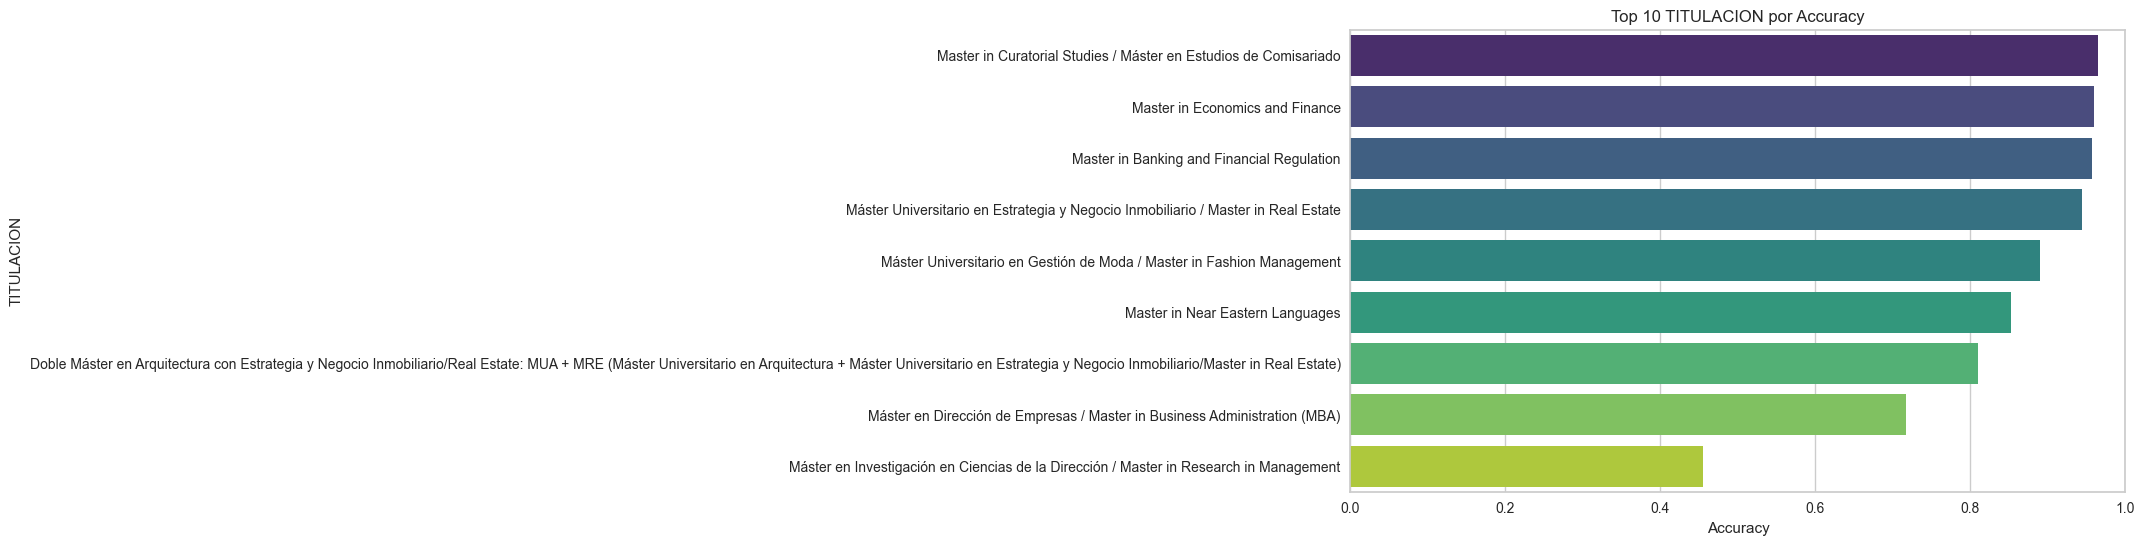


⚠️ ALERTA: 1 TITULACION con Accuracy < 0.7:
                                          TITULACION  Accuracy   n
8  Máster en Investigación en Ciencias de la Dire...     0.455  33

⚠️ No hay columna 'PL_ETAPA' para análisis.

📊 Resultados por PL_SUBETAPA (top 5):
    PL_SUBETAPA     n    AUC  Accuracy  Accuracy_0  Accuracy_1
0   Incompleta   122    NaN     1.000       1.000         NaN
1     Recibida   342    NaN     0.997       0.997         NaN
2     Validada    46    NaN     0.978       0.978         NaN
3    Publicada  2529  0.169     0.977       0.976       1.000
4  Formalizada  8566  0.404     0.943       0.974       0.942

⚠️ Peores 5 PL_SUBETAPA:
                  PL_SUBETAPA     n    AUC  Accuracy  Accuracy_0  Accuracy_1
6                    Enviada     6    NaN     0.833         NaN       0.833
7                     Inicio   371    NaN     0.763       0.763         NaN
8   Matriculado parcialmente  1073    NaN     0.348       0.348         NaN
9             No formalizada    4

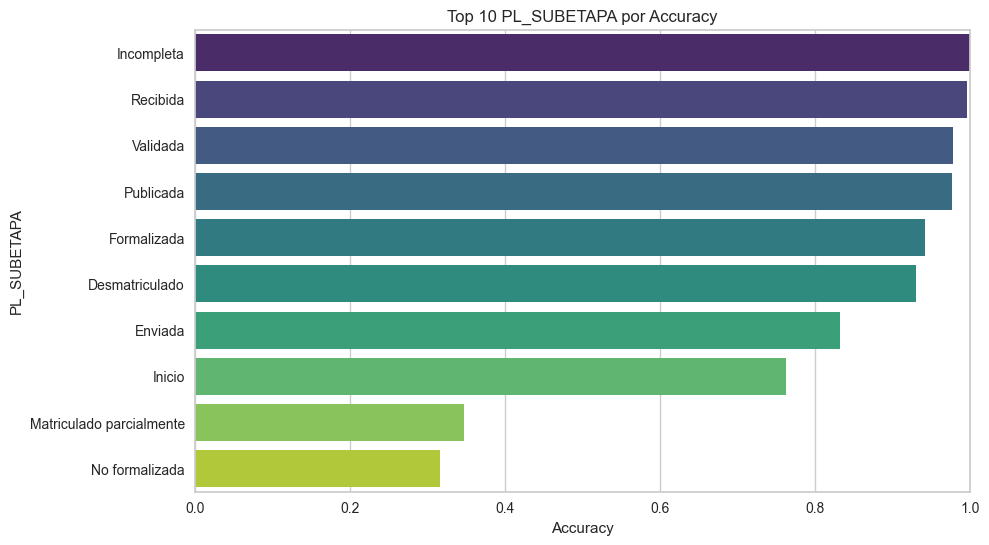


⚠️ ALERTA: 3 PL_SUBETAPA con Accuracy < 0.7:
                 PL_SUBETAPA  Accuracy     n
8   Matriculado parcialmente     0.348  1073
9             No formalizada     0.317    41
10            Prematriculado     0.000    40

✅ Dataset de predicciones post-modelo exportado a Excel en: ..\datos\03. Datos analizados\test_top5_masters_post_model.xlsx

✅ Análisis post-modelo completado con accuracy por clase para máster.


In [ ]:
# ============================================================
# SCRIPT POST-MODELO PARA MÁSTER CON ACCURACY POR CLASE
# ============================================================

import pandas as pd
import numpy as np
from pycaret.classification import load_model, predict_model
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# 0️⃣ CARGA DEL MODELO PARA MÁSTER
# ============================================================

ruta_modelo = r"..\datos\04. Modelos\modelo_final_master"
modelo = load_model(ruta_modelo)
print("✅ Modelo para máster cargado correctamente.")

# ============================================================
# 1️⃣ CARGA DEL DATASET DE TEST
# ============================================================

ruta_dataset = r"..\datos\03. Datos analizados\dataset_clusterizado.csv"
df = pd.read_csv(ruta_dataset, sep=";")
target = 'target'

# Filtrar solo máster
if 'TITULACION' in df.columns:
    df = df[df['TITULACION'].str.contains('MASTER', case=False, na=False)]
else:
    raise ValueError("❌ No existe la columna 'TITULACION' para filtrar por máster.")

# Convertir PL_CURSO_ACADEMICO a numérico
df['PL_CURSO_ACADEMICO'] = pd.to_numeric(df['PL_CURSO_ACADEMICO'], errors='coerce')

# Filtrar por curso académico más reciente disponible
ultimo_curso = df['PL_CURSO_ACADEMICO'].max()
test_df_full = df[df['PL_CURSO_ACADEMICO'] == ultimo_curso].copy()

if test_df_full.empty:
    print("⚠️ No hay datos de máster en el último curso académico. Se usarán todos los cursos disponibles.")
    test_df_full = df.copy()

print(f"✅ Datos de test filtrados. Filas: {len(test_df_full)}")


# ============================================================
# 2️⃣ FILTRAR NAs DEL TARGET
# ============================================================

test_df_full = test_df_full.dropna(subset=[target]).reset_index(drop=True)
print(f"✅ Filas de test después de eliminar NaN en target: {len(test_df_full)}")

# ============================================================
# 3️⃣ VARIABLES DEL MODELO
# ============================================================

vars_excluir = [
    target, 'desmatriculado', 'PAID_PERCENT', 'MINIMUMPAYMENTPAYED',
    'CH_PAGO_SUPERIOR', 'STAGENAME', 'PL_SUBETAPA',
    'ACC_DTT_FECHAULTIMAACTIVIDAD', 'NAMEX', 'YEARPERSONBIRTHDATE'
]

test_X = test_df_full[[c for c in test_df_full.columns if c not in vars_excluir]].copy()
test_y = test_df_full[target].reset_index(drop=True)

# ============================================================
# 4️⃣ RECONSTRUIR FLAGS DE NA Y RELLENAR NAs
# ============================================================

vars_cero_logico = [
    'NU_NOTA_MEDIA_ADMISION',
    'NU_NOTA_MEDIA_1_BACH__PC',
    'NU_RESULTADO_ADMISION_PUNTOS',
    'CU_IMPORTE_TOTAL',
    'CU_precioOrdinario_def__c',
    'CU_precioAplicado_def__c'
]

for v in vars_cero_logico:
    if v in test_X.columns:
        test_X[f'flag_{v}_na'] = test_X[v].isna().astype(int)
        test_X[v] = test_X[v].fillna(0)

# Rellenar cualquier otro NA con 0
test_X = test_X.fillna(0)

# ============================================================
# 5️⃣ PREDICCIONES
# ============================================================

preds = predict_model(modelo, data=test_X)
preds[target] = test_y  # Reenganchar target real

# Añadir columnas originales para análisis
for col in ['TITULACION', 'PL_ETAPA', 'PL_SUBETAPA']:
    if col in test_df_full.columns:
        preds[col] = test_df_full[col].values  # Aseguramos alineación por índice

print(f"✅ Predicciones realizadas. Número de filas: {len(preds)}")

# ============================================================
# 6️⃣ FUNCIONES DE ANÁLISIS
# ============================================================

def analizar_grupo(df, grupo_col, top=5):
    res = []
    for grupo, g in df.groupby(grupo_col):
        if g[target].nunique() == 0:
            continue
        auc = roc_auc_score(g[target], g['prediction_score']) if g[target].nunique() > 1 else np.nan
        acc = accuracy_score(g[target], g['prediction_label'])
        
        # Accuracy por clase
        acc_0 = (g[g[target] == 0]['prediction_label'] == 0).mean() if (g[target] == 0).sum() > 0 else np.nan
        acc_1 = (g[g[target] == 1]['prediction_label'] == 1).mean() if (g[target] == 1).sum() > 0 else np.nan

        res.append({
            grupo_col: grupo,
            'n': len(g),
            'AUC': round(auc,3) if not np.isnan(auc) else auc,
            'Accuracy': round(acc,3),
            'Accuracy_0': round(acc_0,3) if not np.isnan(acc_0) else acc_0,
            'Accuracy_1': round(acc_1,3) if not np.isnan(acc_1) else acc_1
        })
    
    df_res = pd.DataFrame(res).sort_values('Accuracy', ascending=False).reset_index(drop=True)
    return df_res, df_res.head(top), df_res.tail(top)

def plot_top_groups(df, col_name, top=10, metric='Accuracy'):
    df_plot = df.sort_values(metric, ascending=False).head(top)
    plt.figure(figsize=(10,6))
    sns.barplot(data=df_plot, x=metric, y=col_name, palette="viridis")
    plt.title(f"Top {top} {col_name} por {metric}")
    plt.xlim(0,1)
    plt.show()

def alertas_grupo(df, col_name, metric='Accuracy', umbral=0.7):
    alertas = df[df[metric] < umbral]
    if not alertas.empty:
        print(f"\n⚠️ ALERTA: {len(alertas)} {col_name} con {metric} < {umbral}:")
        print(alertas[[col_name, metric, 'n']])
    else:
        print(f"\n✅ Todos los {col_name} tienen {metric} >= {umbral}")

# ============================================================
# 7️⃣ ANÁLISIS POR GRUPO PARA MÁSTER
# ============================================================

# Juan: Concatenar etapa y subetapa para que sea más entendible el resultado del gráfico

for col in ['TITULACION', 'PL_ETAPA', 'PL_SUBETAPA']:
    if col in preds.columns:
        df_group, mejores, peores = analizar_grupo(preds, col)
        print(f"\n📊 Resultados por {col} (top 5):\n", mejores)
        print(f"\n⚠️ Peores 5 {col}:\n", peores)
        plot_top_groups(df_group, col)
        alertas_grupo(df_group, col, metric='Accuracy', umbral=0.7)
    else:
        print(f"\n⚠️ No hay columna '{col}' para análisis.")

# ============================================================
# 8️⃣ EXPORTAR RESULTADOS POST-MODELO A EXCEL
# ============================================================

# Juan: Aquí lo mismo, lo que queremos al final es un conjunto de datos con todo el test, todas las variables iniciales, el target y la predicción.

ruta_excel = r"..\datos\03. Datos analizados\test_top5_masters_post_model.xlsx"
preds.to_excel(ruta_excel, index=False)
print(f"\n✅ Dataset de predicciones post-modelo exportado a Excel en: {ruta_excel}")

print("\n✅ Análisis post-modelo completado con accuracy por clase para máster.")
